# Random Sampling Rodeo

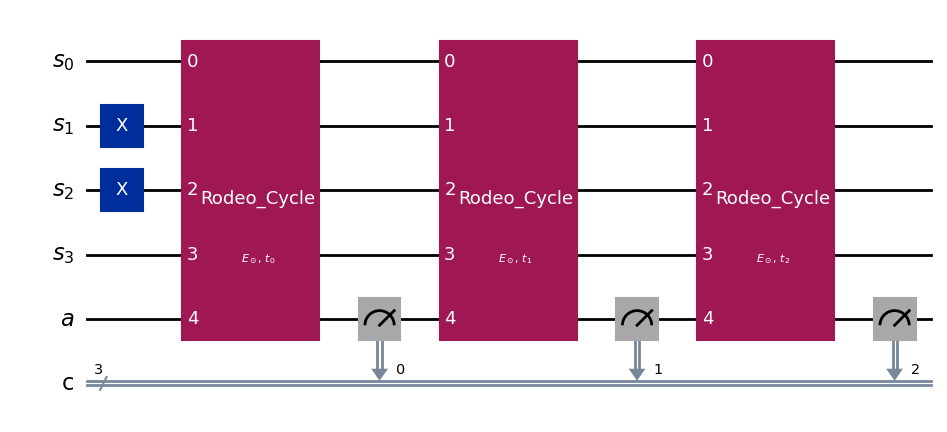

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

# # Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate(J, delta_t):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')

    # The code below created a factor of 2 off
    # hop_circ = QuantumCircuit(2)
    # hop_circ.append(f_gate, [0, 1])
    # hop_circ.ry((J * delta_t) / 2, 0)
    # hop_circ.ry((-1*J * delta_t) / 2, 1)
    # hop_circ.append(g_gate, [0, 1])

    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t), 0)
    hop_circ.ry((-1*J * delta_t), 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label=fr"A_gate_{J}")

# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.rz(2*U * delta_t, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label=fr"B_gate_{U}")

# Define the rodeo cycle
def rodeo_cycle(num_sites, J_value, U_value, t: Parameter, r, targ: Parameter):
    beta = t / r  # Parameter for rotation gates
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    qc = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    qc.h(aux[0])

    # Trotter evolution within this single Rodeo cycle
    A_gate = create_hopping_gate(J=-J_value, delta_t=beta)
    # A_gate = create_hopping_gate(J=-2*J_value, delta_t=beta)
    B_gate = create_onsite_gate(U=U_value, delta_t=beta)

    qc.cz([sys[0], sys[1]], aux[0])
    for _ in range(r):
    
        # qc.cz([sys[0], sys[1]], aux[0])
        # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # qc.cz([sys[0], sys[1]], aux[0])

        # Add CX gates for every other system qubit
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            qc.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # # Add CX gates for every other system qubit again
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])
        
    qc.cz([sys[0], sys[1]], aux[0])


    # Phase rotation based on the energy target and time sample
    qc.p(2*targ * t, aux[0])
    qc.h(aux[0])

    return qc

# Define circuit parameters
num_sites = 2
J_input = 1.5
U_input = 1.0

# Initialize cycling parameters
cycles = 3
superiterations = 5

# Initialize Qiskit parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
si_time = [Parameter(fr'$st_{j}$') for j in range(superiterations)]
steps = 5

# Create a list of target energies at the same length of the cycle
targ_list = [target] * cycles

# Create registers and circuit
classical = ClassicalRegister(cycles, 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(num_sites * 2, 's')
circuit = QuantumCircuit(sys, aux, classical)

circuit.x([sys[1], sys[2]])

# Create circuit with rodeo cycles
for j in range(cycles):
    rodeo_gate= rodeo_cycle(num_sites=2, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label = fr'Rodeo_Cycle'), range(num_sites * 2 + 1))
    circuit.measure(aux, classical[j])  # Ensure that the measurement of `aux` qubit is mapped to the `j`-th classical bit
    

circuit.draw('mpl')


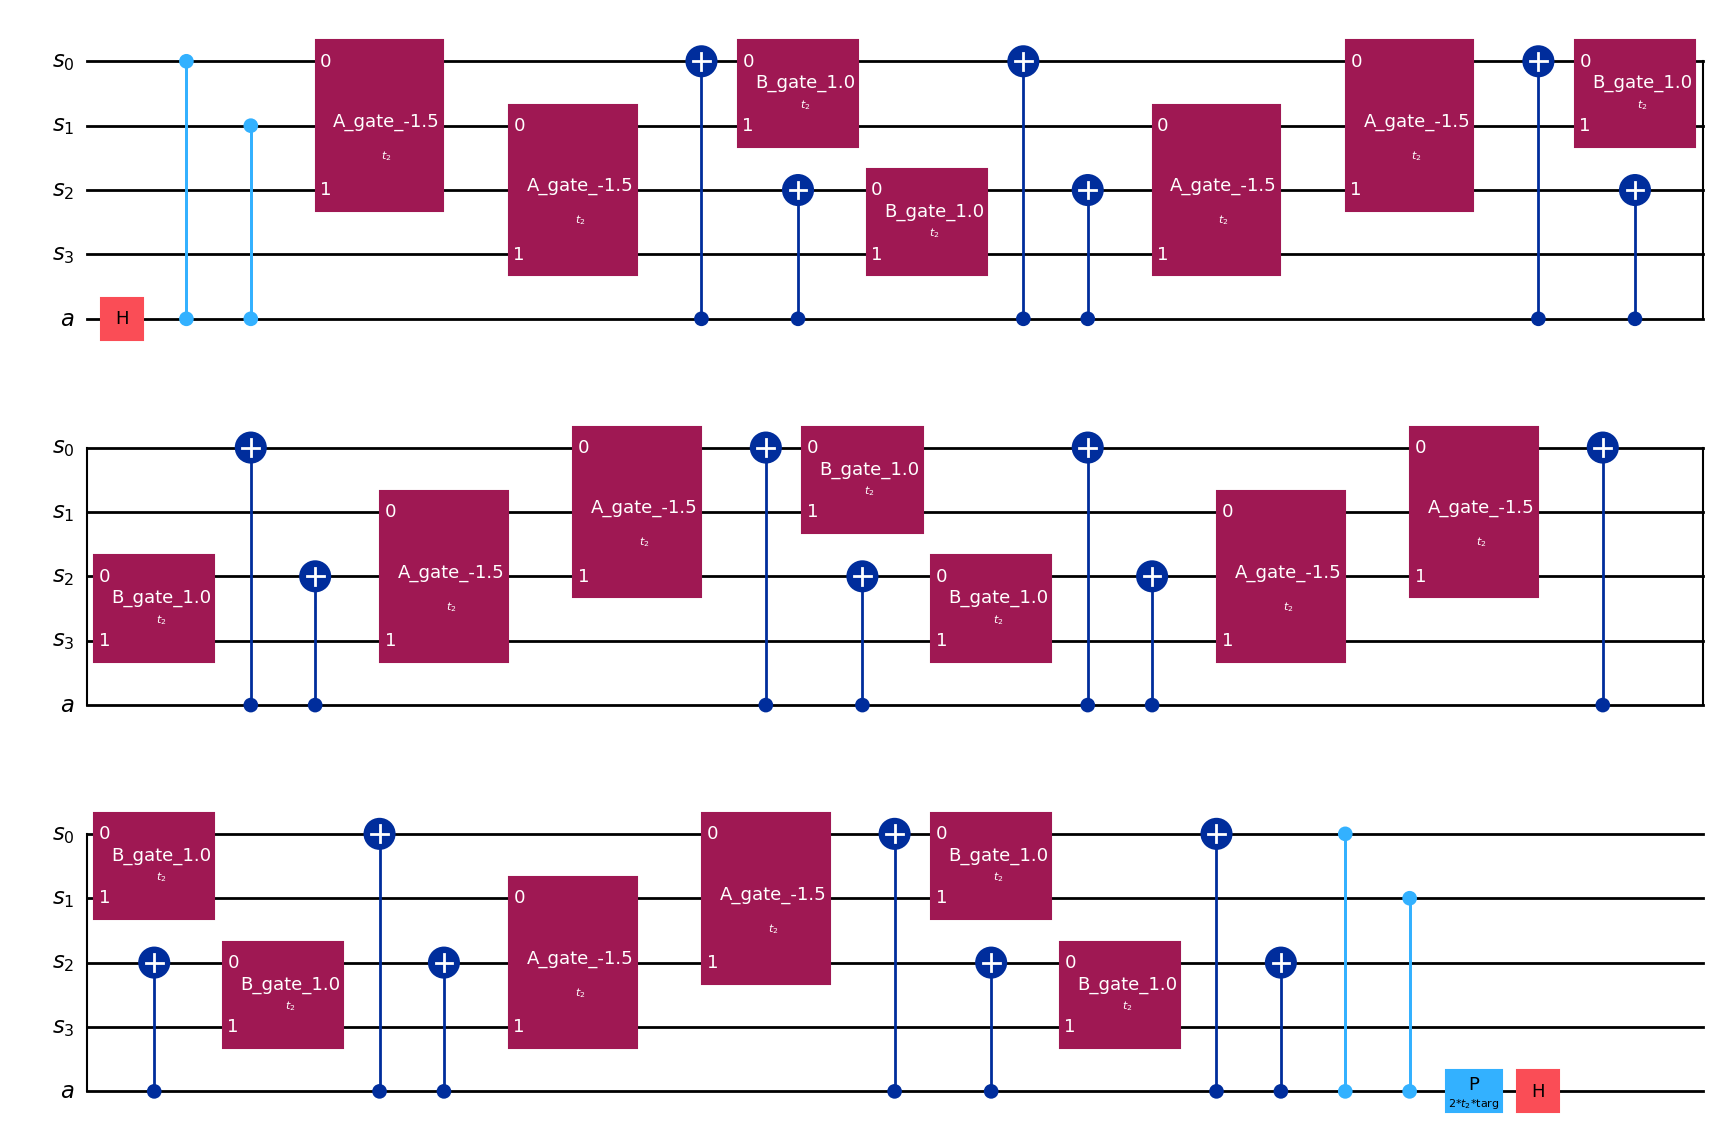

In [3]:
target = Parameter('targ')
rodeo_gate= rodeo_cycle(num_sites=2, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ = target)
rodeo_gate.draw('mpl')

# Superiterations Rodeo

In [2]:
import numpy as np

def create_super_iterations(time_sample: float, iterations: int):
    times_list = np.zeros(iterations + 1)
    
    time = time_sample
    
    for i in range(0, iterations+1):
        time /= 2  # Halve the time each iteration
        times_list[i] = time
    
    return times_list


In [3]:
create_super_iterations(0.5, 5)

array([0.25     , 0.125    , 0.0625   , 0.03125  , 0.015625 , 0.0078125])

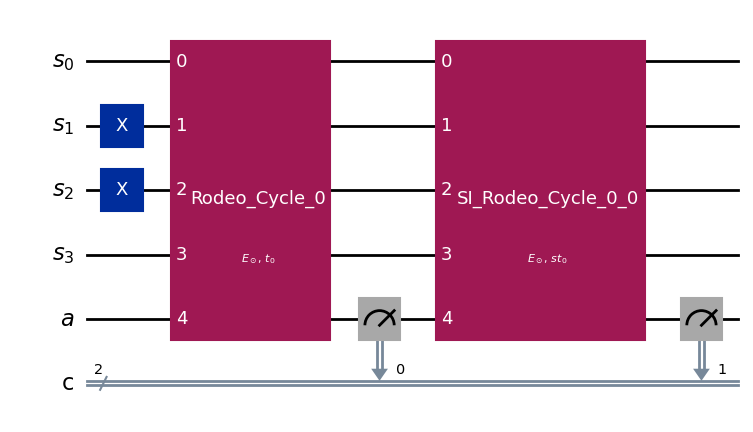

In [4]:
# Define circuit parameters
num_sites = 2
J_input = 4
U_input = 1.0

# Initialize cycling parameters
cycles = 1
iterations = 1

# Initialize Qiskit parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
si_time = [Parameter(fr'$st_{j}$') for j in range(cycles * iterations)]
steps = 5

# Create registers and circuit
classical = ClassicalRegister(cycles * (1 + iterations), 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(num_sites * 2, 's')
circuit = QuantumCircuit(sys, aux, classical)

circuit.x([sys[1], sys[2]])

# Create circuit with alternating rodeo cycles and super iterations
classical_idx = 0
super_idx = 0 

for j in range(cycles):
    rodeo_gate = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label=fr'Rodeo_Cycle_{j}'), range(num_sites * 2 + 1))
    circuit.measure(aux, classical[classical_idx])
    classical_idx += 1 

    # Add super iteration cycles with si_time
    for k in range(iterations):
        rodeo_gate_si = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=si_time[super_idx], r=steps, targ=target)
        circuit.append(rodeo_gate_si.to_gate(label=fr'SI_Rodeo_Cycle_{j}_{k}'), range(num_sites * 2 + 1))
        circuit.measure(aux, classical[classical_idx])
        classical_idx += 1 
        super_idx += 1 

# Draw the circuit
circuit.draw('mpl')


In [5]:
def generate_superiteration_times(tsamples, superiterations, si_time):

    # Validate the size of si_time
    if len(si_time) < len(tsamples) * superiterations:
        raise ValueError("Insufficient si_time parameters for the given cycles and superiterations.")
    
    superiteration_parameter_binds = {}
    

    for i in range(len(tsamples)):

        superiteration_times = []
        time = tsamples[i]
        for _ in range(superiterations):
            time /= 2
            superiteration_times.append(time)
        
        for j in range(superiterations):
            si_index = i * superiterations + j
            superiteration_parameter_binds[si_time[si_index]] = superiteration_times[j]
    
    return superiteration_parameter_binds

In [6]:
from qiskit_aer.primitives import Sampler
# Enumerate scan energies
energymin = -10
energymax = 10
stepsize = 0.1

targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))
targetenergynum = len(targetenergies)
print("Number of target energies:", targetenergynum)

#Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma parameter
gamma = 1

# Amount of "scrambling" of t per target energy. The more random the t the better. 
timeresamples = 10 # Resampling of times for given target energy
shots_per_same_time = 1024

# Create empty list for data
data = []

# Loop through energy list
for i in range(len(targetenergies)):
    
    # Creates dictionary for target energy parameter
    targ_energy = {target : targetenergies[i]}

    # Below is a troubleshooting line you can use to see if the code is scanning through energies properly
    print("Executing for Target Energy:", targ_energy)
    
    # Initialize a list that will contain the results of all 10 resamples for 1 target energy
    targetenergyrun = []
    for _ in range(timeresamples):
        # Creates random time samples for 1 run
        tsamples = ((1 / gamma) * np.random.randn(cycles)).tolist()
        
        # Creates a dictionary to be able to bind time samples to time parameters
        time_parameter_binds = zip(time, tsamples)
        time_parameters = dict(time_parameter_binds)

        superiteration_parameters = generate_superiteration_times(tsamples, superiterations = iterations, si_time=si_time)
        
        # Assigns target energy and time values to parameters
        circuit1 = circuit.assign_parameters(time_parameters, inplace =False)
        circuit2 = circuit1.assign_parameters(targ_energy, inplace = False)
        circuit3 = circuit2.assign_parameters(superiteration_parameters, inplace = False)
        
        # Runs simulation of circuit with values
        sampler = Sampler()
        job = sampler.run(circuit3)
        job.result()
        quasi_dists = job.result().quasi_dists
        
        # Appends the results to list for this target energy
        targetenergyrun.append(quasi_dists)
    
    # The output from above needs to be post-processed as shown below to gain meaning from it:

    # Flattens list of list of dictionaries into just a list of dictionaries
    flattened_list = []
    for sublist in targetenergyrun:
        flattened_list.extend(sublist)

    # Sums and average dictionaries from multiple timeresamples
    combined_dict = {} 
    for dictionary in flattened_list:
        for key, value in dictionary.items():
            combined_dict[key] = combined_dict.get(key, 0) + value

    average_dict = {}
    for key in combined_dict:
        average_dict[key] = combined_dict[key] / timeresamples

    data.append(average_dict)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# This extracts the probabilities for the 0 bitcounts from our obtained data
values_list = []
for d in data:
    if 0 in d:
        values_list.append(d[0])
    else:
        values_list.append(0.0)
print(len(values_list))
print(len(targetenergies))

# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# initial_guess = [
#     1, 0,1

# ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

# Plot the data and the fit
plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
# plt.axvline(x = -0.44, color = 'green', label = 'Ground Energy', linestyle = '--')

plt.legend()
plt.show()

# Print the peaks (centers) of the Gaussians
# n_gaussians = len(fitted_params) // 3
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')


Number of target energies: 200
Executing for Target Energy: {Parameter($E_\odot$): -10.0}
Executing for Target Energy: {Parameter($E_\odot$): -9.899497487437186}
Executing for Target Energy: {Parameter($E_\odot$): -9.798994974874372}
Executing for Target Energy: {Parameter($E_\odot$): -9.698492462311558}
Executing for Target Energy: {Parameter($E_\odot$): -9.597989949748744}


KeyboardInterrupt: 

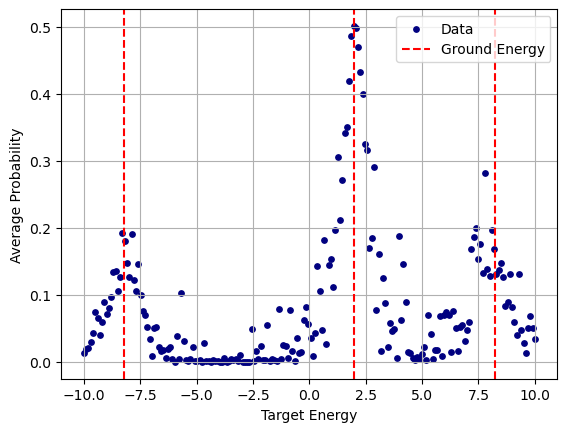

In [12]:
# Plot the data and the fit
plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
plt.axvline(x = -8.24, color = 'red', label = 'Ground Energy', linestyle = '--')
plt.axvline(x = 8.24, color = 'red', linestyle = '--')
plt.axvline(x = 2, color = 'red', linestyle = '--')

plt.legend()
plt.show()

# Print the peaks (centers) of the Gaussians
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')

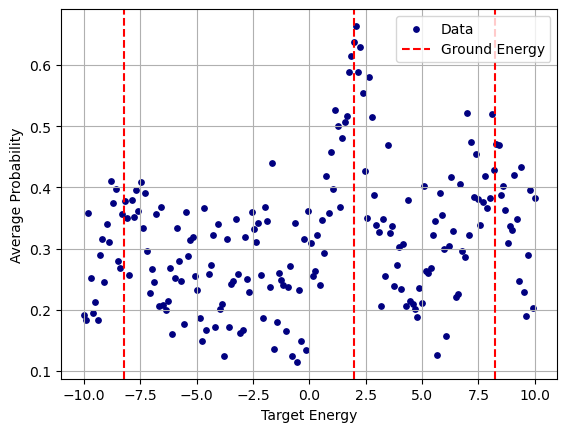

In [10]:
# Plot the data and the fit
plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
plt.axvline(x = -8.24, color = 'red', label = 'Ground Energy', linestyle = '--')
plt.axvline(x = 8.24, color = 'red', linestyle = '--')
plt.axvline(x = 2, color = 'red', linestyle = '--')

plt.legend()
plt.show()

# Print the peaks (centers) of the Gaussians
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')

There is no closed form solution, but to calculate the probability of success is given by:

$$\text{P(N, N}_{{\text{super}}}) = \left[\frac{1}{\sigma\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{\frac{t^2}{2\sigma^2}} \prod_{k=0}^{N_{super}-1} \text{cos}^2\left(\frac{\Delta Et}{2^{k+1}}\right)dt\ \right]^N$$

In [20]:
import numpy as np
from scipy.integrate import quad

def cosine_factors(delta_e, t, n_super):
    """
    Calculate the product of cosine factors for the given superiterations.

    Parameters:
    delta_e (float): Energy difference (Delta E).
    t (float): Time variable for integration.
    n_super (int): Number of superiterations.

    Returns:
    float: Product of cosine factors.
    """
    product = 1.0
    for k in range(n_super):
        product *= np.cos(delta_e * t / (2**(k + 1)))**2
    return product

def p_single_cycle(delta_e, sigma, n_super):
    """
    Numerically calculate P(1, N_super) for a single cycle.

    Parameters:
    delta_e (float): Energy difference (Delta E).
    sigma (float): Standard deviation for Gaussian sampling.
    n_super (int): Number of superiterations.

    Returns:
    float: Success probability for a single cycle.
    """
    # Define the integrand
    def integrand(t):
        gaussian = np.exp(-t**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
        cos_product = cosine_factors(delta_e, t, n_super)
        return gaussian * cos_product

    # Numerically integrate from -inf to +inf
    integral, _ = quad(integrand, -np.inf, np.inf)
    return integral

def p_total(delta_e, sigma, n_super, n_cycles):
    """
    Calculate P(N, N_super) for the Rodeo Algorithm.

    Parameters:
    delta_e (float): Energy difference (Delta E).
    sigma (float): Standard deviation for Gaussian sampling.
    n_super (int): Number of superiterations.
    n_cycles (int): Number of Rodeo cycles.

    Returns:
    float: Total success probability.
    """
    p_1_super = p_single_cycle(delta_e, sigma, n_super)
    return p_1_super**n_cycles

# Example usage
delta_e = 20.0  # Energy difference
sigma = 1.0    # Standard deviation of Gaussian sampling
n_super = 4   # Number of superiterations
n_cycles = 2   # Number of cycles

success_probability = p_total(delta_e, sigma, n_super, n_cycles)
print(f"Success Probability P({n_cycles}, {n_super}): {success_probability:.6f}")


Success Probability P(2, 4): 0.004576


In [22]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve

def cosine_factors(delta_e, t, n_super):
    """
    Calculate the product of cosine factors for the given superiterations.
    """
    product = 1.0
    for k in range(n_super):
        product *= np.cos(delta_e * t / (2**(k + 1)))**2
    return product

def p_single_cycle(delta_e, sigma, n_super):
    """
    Numerically calculate P(1, N_super) for a single cycle.
    """
    def integrand(t):
        gaussian = np.exp(-t**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
        cos_product = cosine_factors(delta_e, t, n_super)
        return gaussian * cos_product

    # Numerically integrate from -inf to +inf
    integral, _ = quad(integrand, -np.inf, np.inf)
    return integral

def p_total(delta_e, sigma, n_super, n_cycles):
    """
    Calculate P(N, N_super) for the Rodeo Algorithm.
    """
    p_1_super = p_single_cycle(delta_e, sigma, n_super)
    return p_1_super**n_cycles

def find_noise_value(sigma, n_super, n_cycles):
    """
    Compute the noise value P_noise by evaluating the success probability
    far from eigenenergies (Delta E >> 0).
    """
    large_delta_e = 10.0  # Arbitrarily large Delta E to simulate being far away
    p_noise = p_total(large_delta_e, sigma, n_super, n_cycles)
    return p_noise

def find_delta_e_noise(sigma, n_super, n_cycles, noise_value):
    """
    Find the Delta E where the success probability matches the noise value.
    """
    def func(delta_e):
        return p_total(delta_e, sigma, n_super, n_cycles) - noise_value

    # Solve for Delta E numerically
    delta_e_guess = 1.0  # Initial guess for Delta E
    delta_e_noise = fsolve(func, delta_e_guess)
    return delta_e_noise[0]

# Example Usage
sigma = 1.0    # Standard deviation of Gaussian sampling
n_super = 1    # Number of superiterations
n_cycles = 1   # Number of Rodeo cycles

# Calculate the noise value
noise_value = find_noise_value(sigma, n_super, n_cycles)
print(f"Noise Value P_noise: {noise_value:.6f}")

# Find the Delta E where the success probability matches the noise value
delta_e_noise = find_delta_e_noise(sigma, n_super, n_cycles, noise_value)
print(f"Delta E where P = P_noise: {delta_e_noise:.6f}")


Noise Value P_noise: 0.500000
Delta E where P = P_noise: 8.323993


C:\Users\sirac\AppData\Local\Temp\ipykernel_9568\3568787765.py:52: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  delta_e_noise = fsolve(func, delta_e_guess)
